In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init, image
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

# 13. Computer Vision
Many applications in the area of computer vision are closely related to our daily lives, now and in the future, whether medical diagnostics, driverless vehicles, camera monitoring, or smart filters. In recent years, deep learning technology has greatly enhanced computer vision systems' performance. It can be said that the most advanced computer vision applications are nearly inseparable from deep learning.

We have introduced deep learning models commonly used in the area of computer vision in the chapter "Convolutional Neural Networks" and have practiced simple image classification tasks. In this chapter, we will introduce image augmentation and fine tuning methods and apply them to image classification. Then, we will explore various methods of object detection. After that, we will learn how to use fully convolutional networks to perform semantic segmentation on images. Then, we explain how to use style transfer technology to generate images that look like the cover of this book. Finally, we will perform practice exercises on two important computer vision datasets to review the content of this chapter and the previous chapters.

## 13.9 Semantic Segmentation and the Dataset
In our discussion of object detection issues in the previous sections, we only used rectangular bounding boxes to label and predict objects in images. In this section, we will look at semantic segmentation, which attempts to segment images into regions with different semantic categories. These semantic regions label and predict objects at the pixel level. `Fig. 13.9.1` shows a semantically-segmented image, with areas labeled `dog`, `cat`, and `background`. As you can see, compared to object detection, semantic segmentation labels areas with pixel-level borders, for significantly greater precision.

<img src="images/13_10.png" style="width:500px;"/>

### 13.9.1 Image Segmentation and Instance Segmentation
In the computer vision field, there are two important methods related to semantic segmentation: 
+ **image segmentation**
+ **instance segmentation** 

Here, we will distinguish these concepts from semantic segmentation as follows:

+ Image segmentation divides an image into several constituent regions. This method generally uses the correlations between pixels in an image. During training, labels are not needed for image pixels. However, during prediction, this method cannot ensure that the segmented regions have the semantics we want. If we input the image in 9.10, image segmentation might divide the dog into two regions, one covering the dog's mouth and eyes where black is the prominent color and the other covering the rest of the dog where yellow is the prominent color.

+ Instance segmentation is also called simultaneous detection and segmentation. This method attempts to identify the pixel-level regions of each object instance in an image. In contrast to semantic segmentation, instance segmentation not only distinguishes semantics, but also different object instances. If an image contains two dogs, instance segmentation will distinguish which pixels belong to which dog.

### 13.9.2 The Pascal VOC2012 Semantic Segmentation Dataset
In the semantic segmentation field, one important dataset is `Pascal VOC2012`. To better understand this dataset, we must first import the package or module needed for the experiment.

The original site might be unstable, so we download the data from a mirror site. The archive is about 2 GB, so it will take some time to download. After you decompress the archive, the dataset is located in the `./data/VOCdevkit/VOC2012` path.

In [2]:
#@save
# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar', 
#                            '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
# voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
voc_dir = './data/VOCdevkit/VOC2012'

Go to `./data/VOCdevkit/VOC2012` to see the different parts of the dataset. The `ImageSets/Segmentation` path contains text files that specify the training and testing examples. The `JPEGImages` and `SegmentationClass` paths contain the example input images and labels, respectively. These labels are also in image format, with the same dimensions as the input images to which they correspond. In the labels, pixels with the same color belong to the same semantic category. The `read_voc_images` function defined below reads all input images and labels to the memory.

In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(image.imread(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(image.imread(os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png')))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

We draw the first five input images and their labels. In the label images, white represents borders and black represents the background. Other colors correspond to different categories.

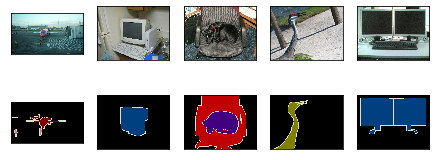

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

Next, we list each RGB color value in the labels and the categories they label.

In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

After defining the two constants above, we can easily find the category index for each pixel in the labels.

In [6]:
#@save
def build_colormap2label():
    """Build an RGB color to label mapping for segmentation."""
    colormap2label = np.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256 + colormap[1])*256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map an RGB color to a label."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

For example, in the first example image, the category index for the front part of the airplane is 1 and the index for the background is 0.

In [7]:
y = voc_label_indices(train_labels[0], build_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 'aeroplane')

##### Data Preprocessing
In the preceding chapters, we scaled images to make them fit the input shape of the model. In semantic segmentation, this method would require us to re-map the predicted pixel categories back to the original-size input image. It would be very difficult to do this precisely, especially in segmented regions with different semantics. To avoid this problem, we crop the images to set dimensions and do not scale them. Specifically, we use the random cropping method used in image augmentation to crop the same region from input images and their labels.

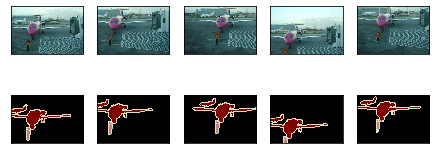

In [8]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop for both feature and label images."""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

##### Dataset Classes for Custom Semantic Segmentation
We use the inherited `Dataset` class provided by `Gluon` to customize the semantic segmentation dataset class `VOCSegDataset`. By implementing the `__getitem__` function, we can arbitrarily access the input image with the index `idx` and the category indexes for each of its pixels from the dataset. As some images in the dataset may be smaller than the output dimensions specified for random cropping, we must remove these example by using a custom `filter` function. In addition, we define the `normalize_image` function to normalize each of the three RGB channels of the input images.

In [9]:
#@save
class VOCSegDataset(gluon.data.Dataset):
    """A customized dataset to load VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = build_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose(2, 0, 1),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

##### Reading the Dataset
Using the custom `VOCSegDataset` class, we create the training set and testing set instances. We assume the random cropping operation output images in the shape $320\times 480$. Below, we can see the number of examples retained in the training and testing sets.

In [10]:
crop_size = (320, 480)
# crop_size = (160, 240)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 306 examples
read 297 examples


We set the batch size to 64 and define the iterators for the training and testing sets. Print the shape of the first minibatch. In contrast to image classification and object recognition, labels here are three-dimensional arrays.

In [11]:
batch_size = 16
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                                   last_batch='discard', timeout=1200,
                                   num_workers=1)

In [12]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(16, 3, 320, 480)
(16, 320, 480)


##### Putting All Things Together
Finally, we define a function `load_data_voc` that downloads and loads this dataset, and then returns the data iterators.

In [13]:
#@save
def load_data_voc(batch_size, crop_size):
    """Download and load the VOC2012 semantic dataset."""
    # voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = gluon.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, last_batch='discard', num_workers=num_workers)
    test_iter = gluon.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), batch_size,
        last_batch='discard', num_workers=num_workers)
    return train_iter, test_iter

##### Summary
+ Semantic segmentation looks at how images can be segmented into regions with different semantic categories.
+ In the semantic segmentation field, one important dataset is Pascal VOC2012.
+ Because the input images and labels in semantic segmentation have a one-to-one correspondence at the pixel level, we randomly crop them to a fixed size, rather than scaling them.

##### Exercises
1. Recall the content we covered in `Section 13.1`. Which of the image augmentation methods used in image classification would be hard to use in semantic segmentation?


## 13.10 Transposed Convolution
The layers we introduced so far for convolutional neural networks, including convolutional layers (`Section 6.2`) and pooling layers (`Section 6.5`), often reduce the input width and height, or keep them unchanged. Applications such as semantic segmentation (`Section 13.9`) and generative adversarial networks (`Section 17.2`), however, require to predict values for each pixel and therefore needs to increase input width and height. Transposed convolution, also named fractionally-strided convolution (`Dumoulin & Visin, 2016`) or deconvolution (`Long et al., 2015`), serves this purpose.

### 13.10.1 Basic 2D Transposed Convolution
Let us consider a basic case that both input and output channels are 1, with 0 padding and 1 stride. `Fig. 13.10.1` illustrates how transposed convolution with a $2\times 2$ kernel is computed on the $2\times 2$ input matrix.

<img src="images/13_11.png" style="width:500px;"/>

We can implement this operation by giving matrix kernel $K$ and matrix input $X$.

In [14]:
def trans_conv(X, K):
    h, w = K.shape
    Y = np.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

Remember the convolution computes results by `Y[i, j] = (X[i: i + h, j: j + w] * K).sum()` (refer to `corr2d` in `Section 6.2`), which summarizes input values through the kernel. While the transposed convolution broadcasts input values through the kernel, which results in a larger output shape.

Verify the results in `Fig. 13.10.1`.

In [15]:
X = np.array([[0, 1], [2, 3]])
K = np.array([[0, 1], [2, 3]])
trans_conv(X, K)

array([[ 0.,  0.,  1.],
       [ 0.,  4.,  6.],
       [ 4., 12.,  9.]])

Or we can use `nn.Conv2DTranspose` to obtain the same results. As `nn.Conv2D`, both input and kernel should be 4-D tensors.

In [16]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.Conv2DTranspose(1, kernel_size=2)
tconv.initialize(init.Constant(K))
tconv(X)

array([[[[ 0.,  0.,  1.],
         [ 0.,  4.,  6.],
         [ 4., 12.,  9.]]]])

### 13.10.2 Padding, Strides, and Channels
We apply padding elements to the input in convolution, while they are applied to the output in transposed convolution. A $1\times 1$ padding means we first compute the output as normal, then remove the first/last rows and columns.

In [17]:
tconv = nn.Conv2DTranspose(1, kernel_size=2, padding=1)
tconv.initialize(init.Constant(K))
tconv(X)

array([[[[4.]]]])

Similarly, strides are applied to outputs as well.

In [18]:
tconv = nn.Conv2DTranspose(1, kernel_size=2, strides=2)
tconv.initialize(init.Constant(K))
tconv(X)

array([[[[0., 0., 0., 1.],
         [0., 0., 2., 3.],
         [0., 2., 0., 3.],
         [4., 6., 6., 9.]]]])

The multi-channel extension of the transposed convolution is the same as the convolution. When the input has multiple channels, denoted by $c_i$, the transposed convolution assigns a $k_h\times k_w$ kernel matrix to each input channel. If the output has a channel size $c_o$, then we have a $c_i\times k_h\times k_w$ kernel for each output channel.

As a result, if we feed $X$ into a convolutional layer $f$ to compute $Y=f(X)$ and create a transposed convolution layer $g$ with the same hyperparameters as $f$ except for the output channel set to be the channel size of $X$, then $g(Y)$ should has the same shape as $X$. Let us verify this statement.

In [19]:
X = np.random.uniform(size=(1, 10, 16, 16))
conv = nn.Conv2D(20, kernel_size=5, padding=2, strides=3)
tconv = nn.Conv2DTranspose(10, kernel_size=5, padding=2, strides=3)
conv.initialize()
tconv.initialize()
tconv(conv(X)).shape == X.shape

True

### 13.10.3 Analogy to Matrix Transposition
The transposed convolution takes its name from the matrix transposition. In fact, convolution operations can also be achieved by matrix multiplication. In the example below, we define a $3\times 3$ input $X$ with a $2\times 2$ kernel $K$, and then use corr2d to compute the convolution output.

In [20]:
X = np.arange(9).reshape(3, 3)
K = np.array([[0, 1], [2, 3]])
Y = d2l.corr2d(X, K)
Y

array([[19., 25.],
       [37., 43.]])

Next, we rewrite convolution kernel $K$ as a matrix $W$. Its shape will be $(4, 9)$, where the $i^\mathrm{th}$ row present applying the kernel to the input to generate the $i^\mathrm{th}$ output element.

In [21]:
def kernel2matrix(K):
    k, W = np.zeros(5), np.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

array([[0., 1., 0., 2., 3., 0., 0., 0., 0.],
       [0., 0., 1., 0., 2., 3., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 2., 3., 0.],
       [0., 0., 0., 0., 0., 1., 0., 2., 3.]])

Then the convolution operator can be implemented by matrix multiplication with proper reshaping.

In [22]:
Y == np.dot(W, X.reshape(-1)).reshape(2, 2)

array([[ True,  True],
       [ True,  True]])

We can implement transposed convolution as a matrix multiplication as well by reusing `kernel2matrix`. To reuse the generated $W$, we construct a $2\times 2$ input, so the corresponding weight matrix will have a shape $(9, 4)$, which is $W^\top$. Let us verify the results.

In [23]:
X = np.array([[0, 1], [2, 3]])
Y = trans_conv(X, K)
Y == np.dot(W.T, X.reshape(-1)).reshape(3, 3)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

##### Summary
+ Compared to convolutions that reduce inputs through kernels, transposed convolutions broadcast inputs.
+ If a convolution layer reduces the input width and height by $n_w$ and $h_h$ time, respectively. Then a transposed convolution layer with the same kernel sizes, padding and strides will increase the input width and height by $n_w$ and $n_h$, respectively.
+ We can implement convolution operations by the matrix multiplication, the corresponding transposed convolutions can be done by transposed matrix multiplication.

##### Exercises
1. Is it efficient to use matrix multiplication to implement convolution operations? Why?


## 13.11 Fully Convolutional Networks (FCN)
We previously discussed semantic segmentation using each pixel in an image for category prediction. A `fully convolutional network` (`FCN`) (`Long et al., 2015`) uses a `convolutional neural network` to transform image pixels to pixel categories. Unlike the `convolutional neural networks` previously introduced, an `FCN` transforms the height and width of the intermediate layer feature map back to the size of input image through the `transposed convolution layer`, so that the predictions have a one-to-one correspondence with input image in spatial dimension (height and width). Given a position on the spatial dimension, the output of the channel dimension will be a category prediction of the pixel corresponding to the location.

We will first import the package or module needed for the experiment and then explain the transposed convolution layer.

### 13.11.1 Constructing a Model
Here, we demonstrate the most basic design of a `fully convolutional network` model. As shown in `Fig. 13.11.1`, the `fully convolutional network` first uses the `convolutional neural network` to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the `transposed convolution layer` `Section 13.10`. The model output has the same height and width as the input image and has a one-to-one correspondence in spatial positions. The final output channel contains the category prediction of the pixel of the corresponding spatial position.

<img src="images/13_12.png" style="width:300px;"/>

Below, we use a `ResNet-18` model pre-trained on the `ImageNet` dataset to extract image features and record the network instance as `pretrained_net`. As you can see, the last two layers of the model member variable features are the global maximum pooling layer `GlobalAvgPool2D` and example flattening layer `Flatten`. The output module contains the fully connected layer used for output. These layers are not required for a `fully convolutional network`.

In [24]:
pretrained_net = gluon.model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ),
 Dense(512 -> 1000, linear))

Next, we create the `fully convolutional network` instance `net`. It duplicates all the neural layers except the last two layers of the instance member variable features of `pretrained_net` and the model parameters obtained after pre-training.

In [25]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

Given an input of a height and width of 320 and 480 respectively, the forward computation of net will reduce the height and width of the input to $1/32$ of the original, i.e., 10 and 15.

In [26]:
X = np.random.uniform(size=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

Next, we transform the number of output channels to the number of categories of Pascal VOC2012 (21) through the $1\times 1$ convolution layer. Finally, we need to magnify the height and width of the feature map by a factor of 32 to change them back to the height and width of the input image. Recall the calculation method for the convolution layer output shape described in `Section 6.3`. Because $(320-64+16\times2+32)/32=10$ and $(480-64+16\times2+32)/32=15$, we construct a transposed convolution layer with a stride of 32 and set the height and width of the convolution kernel to 64 and the padding to 16. It is not difficult to see that, if the stride is $s$, the padding is $s/2$ (assuming $s/2$ is an integer), and the height and width of the convolution kernel are $2s$, the transposed convolution kernel will magnify both the height and width of the input by a factor of $s$.

In [27]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16, strides=32))

### 13.11.2 Initializing the Transposed Convolution Layer
We already know that the transposed convolution layer can magnify a feature map. In image processing, sometimes we need to magnify the image, i.e., upsampling. There are many methods for upsampling, and one common method is bilinear interpolation. Simply speaking, in order to get the pixel of the output image at the coordinates $(x, y)$, the coordinates are first mapped to the coordinates of the input image $(x', y')$. This can be done based on the ratio of the size of three input to the size of the output. The mapped values $x'$ and $y'$ are usually real numbers. Then, we find the four pixels closest to the coordinate $(x', y')$ on the input image. Finally, the pixels of the output image at coordinates $(x, y)$ are calculated based on these four pixels on the input image and their relative distances to $(x', y')$. Upsampling by bilinear interpolation can be implemented by transposed convolution layer of the convolution kernel constructed using the following `bilinear_kernel` function. Due to space limitations, we only give the implementation of the `bilinear_kernel` function and will not discuss the principles of the algorithm.

In [28]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1),
          np.arange(kernel_size).reshape(1, -1))
    filt = (1-np.abs(og[0]-center)/factor) * (1-np.abs(og[1]-center)/factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight)

Now, we will experiment with bilinear interpolation upsampling implemented by transposed convolution layers. Construct a transposed convolution layer that magnifies height and width of input by a factor of 2 and initialize its convolution kernel with the `bilinear_kernel` function.

In [29]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

Read the image `X` and record the result of upsampling as `Y`. In order to print the image, we need to adjust the position of the channel dimension.

In [30]:
img = image.imread('./images/catdog.jpg')
X = np.expand_dims(img.astype('float32').transpose(2, 0, 1), axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose(1, 2, 0)

As you can see, the transposed convolution layer magnifies both the height and width of the image by a factor of 2. It is worth mentioning that, besides to the difference in coordinate scale, the image magnified by bilinear interpolation and original image printed in `Section 13.3` look the same.

input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


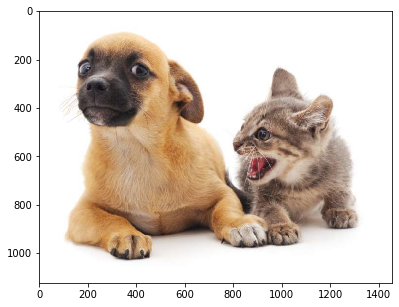

In [31]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation. For a $1\times 1$ convolution layer, we use `Xavier` for randomly initialization.

In [32]:
W = bilinear_kernel(num_classes, num_classes, 64)
net[-1].initialize(init.Constant(W))
net[-2].initialize(init=init.Xavier())

### 13.11.3 Reading the Dataset
We read the dataset using the method described in the previous section. Here, we specify shape of the randomly cropped output image as $320\times 480$, so both the height and width are divisible by 32.

In [33]:
batch_size, crop_size = 8, (320, 480)
# train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

read 306 examples
read 297 examples


### 13.11.4 Training
Now we can start training the model. The loss function and accuracy calculation here are not substantially different from those used in image classification. Because we use the channel of the transposed convolution layer to predict pixel categories, the `axis=1` (channel dimension) option is specified in `SoftmaxCrossEntropyLoss`. In addition, the model calculates the accuracy based on whether the prediction category of each pixel is correct.

loss 0.168, train acc 0.939, test acc 0.828
11.8 examples/sec on [gpu(0)]


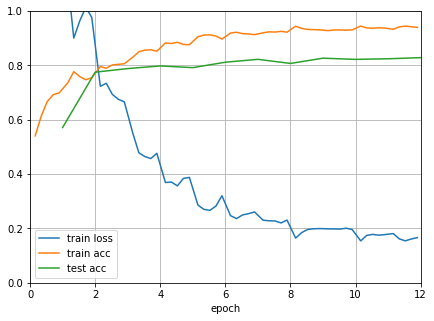

In [34]:
num_epochs, lr, wd, ctx = 12, 0.1, 1e-3, d2l.try_all_gpus()
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd})
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

### 13.11.5 Prediction
During predicting, we need to standardize the input image in each channel and transform them into the four dimensional input format required by the convolutional neural network.

In [35]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = np.expand_dims(X.transpose(2, 0, 1), axis=0)
    pred = net(X.as_in_ctx(ctx[0])).argmax(axis=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

To visualize the predicted categories for each pixel, we map the predicted categories back to their labeled colors in the dataset.

In [36]:
def label2image(pred):
    colormap = np.array(d2l.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

The size and shape of the images in the test dataset vary. Because the model uses a transposed convolution layer with a stride of 32, when the height or width of the input image is not divisible by 32, the height or width of the transposed convolution layer output deviates from the size of the input image. In order to solve this problem, we can crop multiple rectangular areas in the image with heights and widths as integer multiples of 32, and then perform forward computation on the pixels in these areas. When combined, these areas must completely cover the input image. When a pixel is covered by multiple areas, the average of the transposed convolution layer output in the forward computation of the different areas can be used as an input for the softmax operation to predict the category.

For the sake of simplicity, we only read a few large test images and crop an area with a shape of $320\times480$ from the top-left corner of the image. Only this area is used for prediction. For the input image, we print the cropped area first, then print the predicted result, and finally print the labeled category.

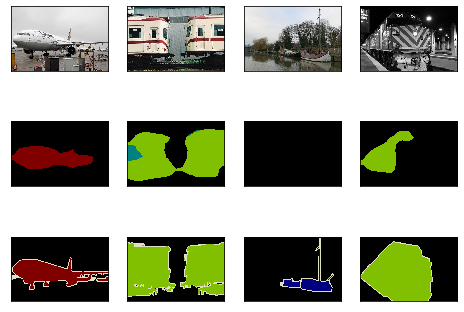

In [37]:
# voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

##### Summary
+ The fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer to output the category of each pixel.
+ In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation.

##### Exercises
1. If we use `Xavier` to randomly initialize the transposed convolution layer, what will happen to the result?
2. Can you further improve the accuracy of the model by tuning the hyperparameters?
3. Predict the categories of all pixels in the test image.
4. The outputs of some intermediate layers of the convolutional neural network are also used in the paper on fully convolutional networks[1]. Try to implement this idea.